In [226]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import folium as fm
from datetime import datetime as dt
from datetime import timedelta
import datetime
from folium.plugins import HeatMap, MarkerCluster
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import math
from shapely.geometry import Polygon
import geopandas
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
import matplotlib.patches as mpatches


In [2]:
process_data = pd.read_csv('2015_tree_process.csv')

In [3]:
process_data.head()

,tree_id,borough,zipcode,latitude,longitude,tree_dbh,spc_common,health,Median_Individual_Income,Median_Resident_Age,...,post_office,neighborhood,population,density,family,health_class,borough_class,tree_class,tree_family_class,comlaint_count
0,180683,Queens,11375,40.723092,-73.844215,3,red maple,Fair,84617.0,43.5,...,"Forest Hills, NY",West Central Queens,68733,34707,Aceraceae,2,1,1.0,0,783.0
1,203550,Queens,11375,40.713170,-73.854446,42,London planetree,Good,84617.0,43.5,...,"Forest Hills, NY",West Central Queens,68733,34707,Platanaceae,1,1,1.0,1,783.0
2,193183,Queens,11375,40.717032,-73.838297,3,Amur maple,Good,84617.0,43.5,...,"Forest Hills, NY",West Central Queens,68733,34707,Aceraceae,1,1,3.0,0,783.0
3,203577,Queens,11375,40.712480,-73.855020,26,London planetree,Good,84617.0,43.5,...,"Forest Hills, NY",West Central Queens,68733,34707,Platanaceae,1,1,1.0,1,783.0
4,203386,Queens,11375,40.712641,-73.852138,26,London planetree,Good,84617.0,43.5,...,"Forest Hills, NY",West Central Queens,68733,34707,Platanaceae,1,1,1.0,1,783.0


In [5]:
process_data.shape

(639851, 21)

## DBH & Health

In [1208]:
dbh_data = process_data[process_data.tree_dbh!=0][['tree_id','tree_dbh',
                                                   'health','zipcode','latitude','longitude','family'
                                                   ,'spc_common']]
dbh_data = dbh_data[dbh_data.health!='Dead']


In [1209]:
dbh_data.tree_dbh.describe()

count    639635.000000
mean         11.765347
std           8.657841
min           1.000000
25%           5.000000
50%          10.000000
75%          16.000000
max         425.000000
Name: tree_dbh, dtype: float64

In [1210]:
bins = [0,5,10,15,20,30,40,50,100,500]
group_names = [5,10,15,20,30,40,50,100,500]
s = pd.cut(dbh_data.tree_dbh,bins,labels = group_names)
dbh_data['dbh_label'] = s

In [1249]:
dbh_health = dbh_data.groupby(['dbh_label','health']).agg({
    'tree_id':'count'
}).reset_index()
dbh_health = dbh_health.pivot(index='dbh_label',columns='health',values='tree_id')

In [1250]:
dbh_health['sum'] = dbh_health.apply(lambda x: x.sum(),axis=1)
dbh_health['Fair%'] = dbh_health.apply(lambda x:x['Fair']/x['sum'],axis=1)
dbh_health['Good%'] = dbh_health.apply(lambda x:x['Good']/x['sum'],axis=1)
dbh_health['Poor%'] = dbh_health.apply(lambda x:x['Poor']/x['sum'],axis=1)

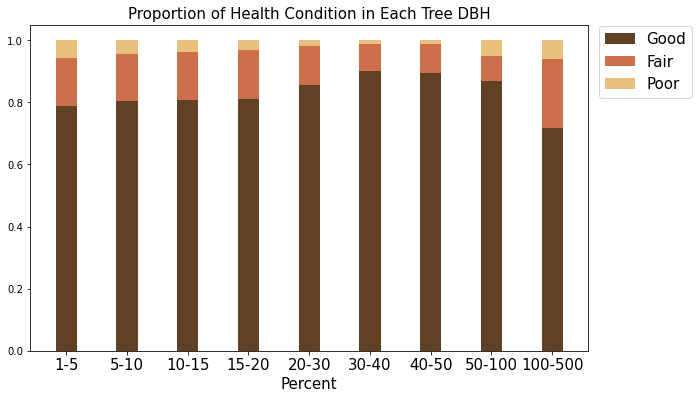

In [1256]:
plt.figure(figsize=(10,6))
borough = [5,10,15,20,30,40,50,100,500]
color_list = ['#7C6A0A','#1A3C40','#4E944F','#9FC088','#E9EFC0','#DACC96','#E8C07D','#CC704B','#9D5353','#632626','#614124']
x = range(len(borough))
plt.xticks(x, ['1-5','5-10','10-15','15-20','20-30','30-40','40-50','50-100','100-500'],fontsize=15)
Bottom = dbh_health['Good%']
Center1 = dbh_health['Fair%']
Center2 = dbh_health['Poor%']

B_Center1 = []
C1_Center2 =[]
for i in range(0, len(Bottom)):
    sum=Bottom[i]+Center1[i]
    B_Center1.append(sum)
    sum = Bottom[i] + Center1[i] + Center2[i]
    C1_Center2.append(sum)

width = 0.35
p1 = plt.bar(x, Bottom, width, color='#614124')  
p2 = plt.bar(x, Center1, width, bottom=Bottom, color='#CC704B')
p3 = plt.bar(x, Center2, width, bottom=B_Center1, color='#E8C07D')
# p4 = plt.bar(x, Top, width, bottom=C1_Center2, color='#9FC088') 
plt.xlabel('DBH Classes',fontsize=15)
plt.xlabel('Percent',fontsize=15)
plt.title('Proportion of Health Condition in Each Tree DBH',fontsize=15)
plt.legend((p1[0], p2[0], p3[0]), ('Good', 'Fair', 'Poor'),bbox_to_anchor=(1.2,1.02),loc = 'best',fontsize=15)
# plt.ylim(0,100)
plt.savefig('result/dbh_health.png',bbox_inches = 'tight')
plt.show()

## Height & Health

In [491]:
height_health = process_data[process_data['health']!='Dead'].groupby(['tree_class','health']).agg({
    'tree_id':'count'
}).reset_index()
height_count = process_data[process_data['health']!='Dead'].groupby(['tree_class']).agg({
    'tree_id':'count'
}).reset_index()

In [494]:
height_health['percent'] = height_health.apply(lambda x: int(x['tree_id']) /
                                               int(height_count[height_count['tree_class']==x['tree_class']]['tree_id']) * 100, axis=1 )
height_health = height_health.pivot(index='tree_class',columns='health',values='percent')
height_health

health,Fair,Good,Poor
tree_class,,,
1.0,14.973109,81.115107,3.911784
2.0,18.290368,74.561126,7.148505
3.0,13.843319,81.963243,4.193438
4.0,15.137739,79.440012,5.422249


In [495]:
height_health = height_health.reset_index()

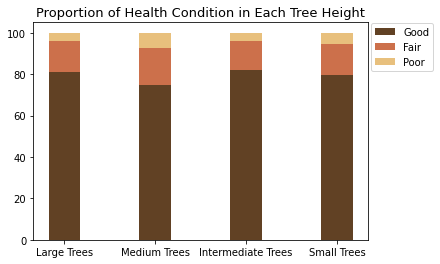

In [1108]:
borough = [1.0,2.0,3.0,4.0]
color_list = ['#7C6A0A','#1A3C40','#4E944F','#9FC088','#E9EFC0','#DACC96','#E8C07D','#CC704B','#9D5353','#632626','#614124']
x = range(len(borough))
plt.xticks(x, ['Large Trees','Medium Trees','Intermediate Trees','Small Trees'])
Bottom = height_health['Good']
Center1 = height_health['Fair']
Center2 = height_health['Poor']

B_Center1 = []
C1_Center2 =[]
for i in range(0, len(Bottom)):
    sum=Bottom[i]+Center1[i]
    B_Center1.append(sum)
    sum = Bottom[i] + Center1[i] + Center2[i]
    C1_Center2.append(sum)

width = 0.35
p1 = plt.bar(x, Bottom, width, color='#614124')  
p2 = plt.bar(x, Center1, width, bottom=Bottom, color='#CC704B')
p3 = plt.bar(x, Center2, width, bottom=B_Center1, color='#E8C07D')
# p4 = plt.bar(x, Top, width, bottom=C1_Center2, color='#9FC088') 
plt.title('Proportion of Health Condition in Each Tree Height',fontsize=13)
plt.legend((p1[0], p2[0], p3[0]), ('Good', 'Fair', 'Poor'),bbox_to_anchor=(1.21,1.02),loc = 'best')
# plt.ylim(0,100)
plt.savefig('result/height_health.png',bbox_inches = 'tight')
plt.show()

## Family & Health
### Top 10 Tree Families with the Highest Percentage of Poor/Good

In [27]:
family_count = process_data.groupby(['family']).agg({
    'tree_id':'count'
}).reset_index()

In [77]:
family_health = process_data.groupby(['family','health']).agg({
    'tree_id':'count'
}).reset_index()

In [78]:
family_health['percent'] = family_health.apply(lambda x: int(x['tree_id']) /
                                               int(family_count[family_count['family']==x['family']]['tree_id']) * 100, axis=1 )


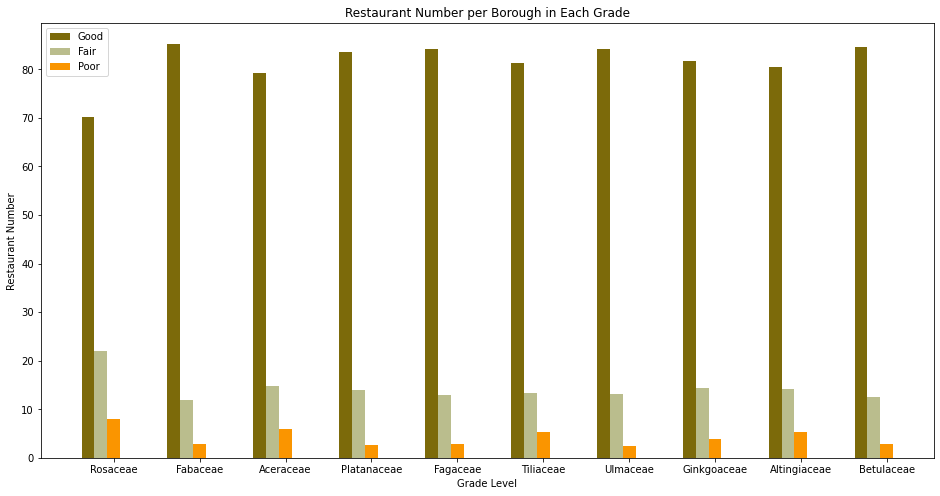

In [79]:
plt.figure(figsize=(16,8))
width = 0.15
most_family = family_count.sort_values('tree_id',ascending=False).head(10).family.values
family_health_1 = family_health[family_health['family'].isin(most_family)]
health_list = ['Good','Fair','Poor']
colors = ["#7C6A0A","#BABD8D","#FA9500","#FFDAC6","#EB6424"]
xsticks = np.arange(len(most_family))

for i in range(0,len(health_list)):
    plt.bar(xsticks + width * i,
            family_health_1.loc[family_health_1['health'] == health_list[i]]['percent'],
            width,
            label = health_list[i],
            color = colors[i])
plt.title("Restaurant Number per Borough in Each Grade")
plt.xlabel("Grade Level")
plt.ylabel("Restaurant Number")
plt.xticks(xsticks + width * 2, labels=most_family)
plt.legend()
plt.show()

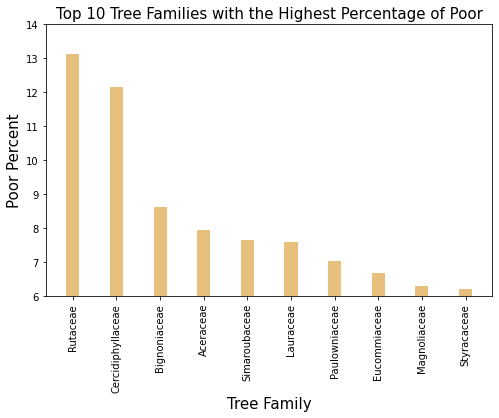

In [1078]:
plt.figure(figsize=(8,5))
plt.bar(range(10),
            family_health[family_health['health']=='Poor'].sort_values('percent',ascending=False).head(10)['percent'],
            width=0.3,color="#E8C07D")
plt.title("Top 10 Tree Families with the Highest Percentage of Poor",fontsize=15)
plt.xticks(rotation=90)
plt.xlabel("Tree Family",fontsize=15)
plt.ylabel("Poor Percent",fontsize=15)
plt.xticks(range(10), labels=family_health[family_health['health']=='Poor'].sort_values(
    'percent',ascending=False).head(10)['family'])
plt.ylim(6,14)
plt.savefig('result/Top_10_Families_with_Highest_Poor.png',bbox_inches = 'tight')
plt.show()

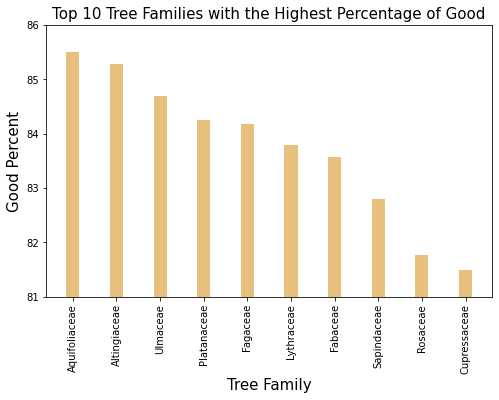

In [1136]:
plt.figure(figsize=(8,5))
plt.bar(range(10),
            family_health[family_health['health']=='Good'].sort_values('percent',ascending=False).head(10)['percent'],
            width=0.3,color="#E8C07D")
plt.title("Top 10 Tree Families with the Highest Percentage of Good",fontsize=15)
plt.xticks(rotation=90)
plt.xlabel("Tree Family",fontsize=15)
plt.ylabel("Good Percent",fontsize=15)
plt.xticks(range(10), labels=family_health[family_health['health']=='Good'].sort_values(
    'percent',ascending=False).head(10)['family'])

plt.ylim(81,86)
plt.savefig('result/Top_10_Families_with_Highest_Good.png',bbox_inches = 'tight')
plt.show()

### Top 10 Tree Families in Each Health Condition (Poor/Good)

In [115]:
health_family = process_data.groupby(['health','family']).agg({
    'tree_id':'count'
}).reset_index()
health_count = process_data.groupby(['health']).agg({
    'tree_id':'count'
}).reset_index()

In [117]:
health_family['percent'] = health_family.apply(lambda x: int(x['tree_id']) /
                                               int(health_count[health_count['health']==x['health']]['tree_id']) * 100, axis=1 )


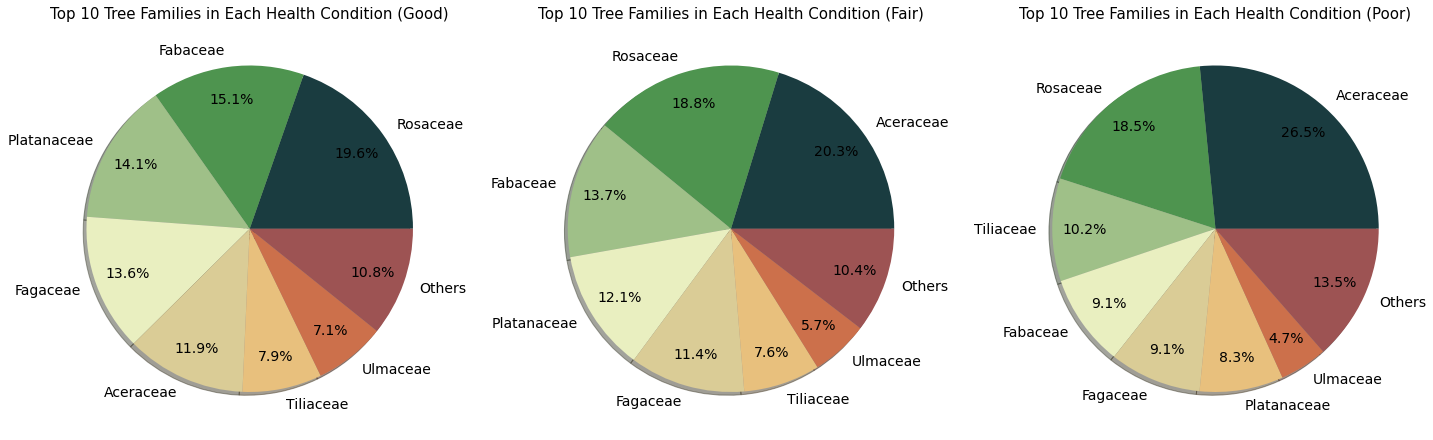

In [1098]:
Good_10 = health_family[health_family['health']=='Good'].sort_values('percent',ascending=False).head(7)
Good_10 = Good_10.append(pd.DataFrame([['Good','Others',0,100-Good_10.percent.sum()]],columns=Good_10.columns))
# plt.figure(figsize=(20,5))
# colors = ["#7C6A0A","#BABD8D","#FA9500","#EB6424",'#FFC300','#FF5733','#C70039','#900C3F','#581845',"#FFDAC6"]
colors=['#1A3C40','#4E944F','#9FC088','#E9EFC0','#DACC96','#E8C07D','#CC704B','#9D5353','#632626','#614124']
expl_B = [0.1,0,0]

fig, ax = plt.subplots(1,3,figsize=(20, 6), constrained_layout=True)
ax[0].pie(Good_10['percent'],colors = colors, labels=Good_10.family, autopct='%1.1f%%',pctdistance=0.8, shadow=True,
       textprops={'fontsize':14})
ax[0].set_title('Top 10 Tree Families in Each Health Condition (Good)',size=15)
# ax[0].legend(title='Families',bbox_to_anchor=(1.4,1.02),loc = 'best')
# plt.show()

Fair_10 = health_family[health_family['health']=='Fair'].sort_values('percent',ascending=False).head(7)
Fair_10 = Fair_10.append(pd.DataFrame([['Fair','Others',0,100-Fair_10.percent.sum()]],columns=Fair_10.columns))
ax[1].pie(Fair_10['percent'],colors = colors, labels=Fair_10.family, autopct='%1.1f%%',pctdistance=0.8, shadow=True,
       textprops={'fontsize':14})
ax[1].set_title('Top 10 Tree Families in Each Health Condition (Fair)',size=15)

Poor_10 = health_family[health_family['health']=='Poor'].sort_values('percent',ascending=False).head(7)
Poor_10 = Poor_10.append(pd.DataFrame([['Fair','Others',0,100-Poor_10.percent.sum()]],columns=Poor_10.columns))
ax[2].pie(Poor_10['percent'],colors = colors, labels=Poor_10.family, autopct='%1.1f%%',pctdistance=0.8, shadow=True,
       textprops={'fontsize':14})
ax[2].set_title('Top 10 Tree Families in Each Health Condition (Poor)',size=15)

fig.savefig('result/top_10_family_in_health_condition.png')

## Health & Location

In [215]:
data_all = pd.read_csv('2015_tree_dead.csv')
data_all = data_all.dropna(subset=['health'])
data_all.shape

(675980, 16)

In [223]:
final_df = data_all
health_class = {"Good":1,"Fair":2,"Poor":3,"Dead":4}
final_df ['health_class'] = final_df['health'].apply(lambda x: health_class.get(x))
borough_class = {"Queens":1,"Brooklyn":2,"Staten Island":3,"Bronx":4,"Manhattan":5}
final_df ['borough_class'] = final_df['borough'].apply(lambda x: borough_class.get(x))

tree_class={'Schubert':4,'chokecherry':3,'American beech':1,'American elm':1,'American hophornbeam':3,
 'American hornbeam':3,'American larch':2,'American linden':1,'Amur cork tree':3,'Amur maackia':4,
 'Amur maple':3,'Atlantic white cedar':1,'Atlas cedar':1,'Callery pear':3,'Chinese chestnut':1,'Chinese elm':1,
    'Chinese fringetree':4,'Chinese tree lilac':4,'Cornelian cherry':4,'Douglas-fir':1,'English oak':1,
 'European alder':1,'European beech':1,'European hornbeam':3,'Himalayan cedar':1,'Japanese hornbeam':4,
 'Japanese maple':4,'Japanese snowbell':3,'Japanese tree lilac':4,'Japanese zelkova':1,
 'Kentucky coffeetree':1,'Kentucky yellowwood':2,'London planetree':1,'Norway maple':1,'Norway spruce':1,
 'Ohio buckeye':1,'Oklahoma redbud':3,'Osage-orange':3,'Persian ironwood':3,"Schumard's oak":1,'Scots pine':1,
 'Shantung maple':3,'Siberian elm':1,'Sophora':1,'Turkish hazelnut':2,'Virginia pine':1,'arborvitae':1,'ash':1,
 'bald cypress':1,'bigtooth aspen':1,'black cherry':1,'black locust':1,'black maple':1,'black oak':1,
 'black pine':2,'black walnut':1,'blackgum':2,'blue spruce':1,'boxelder':2,
 'bur oak':1,'catalpa':2,'cherry':3,'cockspur hawthorn':4,'common hackberry':2,'crab apple':4,
 'crepe myrtle':4,'crimson king maple':2,'cucumber magnolia':1,'dawn redwood':1,
 'eastern cottonwood':1,'eastern hemlock':1,'eastern redbud':4,'eastern redcedar':2,'empress tree':2,
 'false cypress':1,'flowering dogwood':4,'ginkgo':3,'golden raintree':3,'green ash':1,
 'hardy rubber tree':1,'hawthorn':4,'hedge maple':3,'holly':2,'honeylocust':1,
 'horse chestnut':1,'katsura tree':2,'kousa dogwood':4,'littleleaf linden':1,'magnolia':1,'maple':1,
 'mimosa':4,'mulberry':1,'northern red oak':1,'pagoda dogwood':4,'paper birch':4,'paperbark maple':4,
 'pignut hickory':1,'pin oak':1,'pine':1,'pitch pine':1,'pond cypress':1,'purple-leaf plum':4,
 'quaking aspen':1,'red horse chestnut':2,'red maple':1,'red pine':1,'river birch':1,'sassafras':2,
 'sawtooth oak':1,'scarlet oak':1,'serviceberry':4,'shingle oak':1,'silver birch':1,'silver linden':1,
 'silver maple':1,'smoketree':4,'southern magnolia':1,'southern red oak':1,'spruce':1,'sugar maple':1,
 'swamp white oak':1,'sweetgum':1,'sycamore maple':1,'tartar maple':4,'tree of heaven':1,'trident maple':3,
 'tulip-poplar':1,'two-winged silverbell':3,'weeping willow':3,
 'white ash':1,'white oak':1,'white pine':1,'willow oak':1}

final_df ['tree_class'] = final_df['spc_common'].apply(lambda x: tree_class.get(x))

family_df = pd.DataFrame(final_df["family"].unique()).reset_index()
family_df.columns=["family","tree_family_class"]
family_df = dict(zip(family_df['tree_family_class'],family_df['family']))
final_df ['tree_family_class'] = final_df['family'].apply(lambda x: family_df.get(x))
final_df []

In [1263]:
geo_df.shape

(675980, 24)

### detect pattern

In [248]:
geo_df[geo_df['health']=="Dead"].shape

(31266, 21)

In [981]:
def grid_cell(df_spatial):  
    # Set up cell size (Square)
    lon_range = (df_spatial.longitude.min(), df_spatial.longitude.max())
    lon_cells = 75

    lat_range = (df_spatial.latitude.min(), df_spatial.latitude.max())
    lat_cells = 75

    lon_incr = (lon_range[1] - lon_range[0]) / lon_cells
    lat_incr = (lat_range[1] - lat_range[0]) / lat_cells
    x0, y0 = lon_range[0], lat_range[0]

    cell_ids = []
    grid_cells = []
    for c in range(lon_cells):
        x1 = x0 + lon_incr
        for r in range(lat_cells):
            y1 = y0 + lat_incr
            grid_cells.append(Polygon([(x0,y0),(x0,y1),(x1,y1),(x1,y0)]))
            cell_ids.append('{:02d}_{:02d}'.format(c, r))
            y0 = y1
        x0 = x1
        y0 = lat_range[0]

    # Assign cell id according to their latitude and longitude
    df_spatial['grid_x']   = np.floor((df_spatial['longitude'] - lon_range[0]) / (lon_range[1] - lon_range[0]) * lon_cells).astype(int)
    df_spatial['grid_y']   = np.floor((df_spatial['latitude']  - lat_range[0]) / (lat_range[1] - lat_range[0]) * lat_cells).astype(int)
    # The cell_id column will be used to link our aggregate data to the grid GeoJSON object for plotting
    df_spatial['cell_id']  = df_spatial[['grid_x','grid_y']].apply(lambda x: '{:02d}_{:02d}'.format(x.grid_x, x.grid_y), axis=1)
    df_spatial.reset_index(inplace=True,drop=True)
    # Choose aggregation method with largest range of values
    df_agg = df_spatial.groupby(['longitude','latitude','cell_id'])['tree_id'].count().reset_index().rename(columns={'tree_id':'Count'})
    df_cell = df_agg.groupby(['cell_id'])['Count'].agg(['sum','mean','median','max','min']).reset_index()
    return df_spatial,df_agg,df_cell,lat_range,lon_range,lon_cells,lat_cells



In [995]:
def plot_grid_map(df_cell,lat_range,lon_range,lon_cells,lat_cells):
    # Plot the grid map

    stat_compare = 'sum'
    data = df_cell[['cell_id',stat_compare]]

    ## Color
    cb2_ordrd_rgb = [(255,237,160),(254,217,118),(254,178,76),(253,141,60),(252,78,42),(227,26,28),(189,0,38),(128,0,38),(103,0,13)]


    ## Set up the base map
    m = fm.Map(tiles='cartodbpositron', width='100%', height='100%') # If you adjusted the notebook display width to be as wide as your screen, the map might get very big. Adjust size as desired.
    m.fit_bounds([[lat_range[0], lon_range[0]], [lat_range[1], lon_range[1]]])

    lon_incr = (lon_range[1] - lon_range[0]) / lon_cells
    lat_incr = (lat_range[1] - lat_range[0]) / lat_cells

    min_val = data[stat_compare].min()
    max_val = data[stat_compare].max()

    ncol = len(cb2_ordrd_rgb)
    col_range = 1 / (ncol-1)

    for c in range(lon_cells):
        for h in range(lat_cells):
            cell_id = '{:02d}_{:02d}'.format(c,h)

            if (data.cell_id == cell_id).any():
                val = data.loc[data.cell_id == cell_id,stat_compare].reset_index(drop=True)[0]
            else:
                val = 0
            nval = (val - min_val) / (max_val - min_val)
            col_int = divmod(nval, col_range)
            ci = int(col_int[0])
            r = col_int[1] / col_range
            if (r > 0.0 and ci < ncol):
                c0 = cb2_ordrd_rgb[ci]
                c1 = cb2_ordrd_rgb[ci+1]
                col = (
                    int((1.0-r)*c0[0] + r*c1[0]),
                    int((1.0-r)*c0[1] + r*c1[1]),
                    int((1.0-r)*c0[2] + r*c1[2])
                )
                c_string = '#{:02x}{:02x}{:02x}'.format(col[0], col[1], col[2])

            if (val > 0):
                fm.Rectangle(bounds = [(lat_range[0]+h*lat_incr, lon_range[0]+ c*lon_incr),(lat_range[0]+(h + 1)*lat_incr, lon_range[0]+ (c + 1)*lon_incr)]
                          #, radius=500
                          , color=c_string, fill_color=c_string, fill=True, weight=0, fill_opacity=0.6+(nval*0.5), popup=stat_compare+ ': {}'.format(val)).add_to(m)

#     title_html = '''
#                  <h4 align="center" style="font-size:12px"><b>{}</b></h3>
#                  '''.format('Health = Good (2015)')
#     m.get_root().html.add_child(fm.Element(title_html))

    return m

## Heatmap

In [ ]:
df_spatial = geo_df[geo_df['health']=="Good"]
df_spatial,df_agg,df_cell,lat_range,lon_range,lon_cells,lat_cells = grid_cell(df_spatial)
heatmap = plot_grid_map(df_cell,lat_range,lon_range,lon_cells,lat_cells)
heatmap.save('result/Good_heatmap.html')

In [ ]:
df_spatial = geo_df[geo_df['health']=="Fair"]
df_spatial,df_agg,df_cell,lat_range,lon_range,lon_cells,lat_cells = grid_cell(df_spatial)
heatmap = plot_grid_map(df_cell,lat_range,lon_range,lon_cells,lat_cells)
heatmap.save('result/Fair_heatmap.html')

In [ ]:
df_spatial = geo_df[geo_df['health']=="Poor"]
df_spatial,df_agg,df_cell,lat_range,lon_range,lon_cells,lat_cells = grid_cell(df_spatial)
heatmap = plot_grid_map(df_cell,lat_range,lon_range,lon_cells,lat_cells)
heatmap.save('result/Poor_heatmap.html')

In [ ]:
df_spatial = geo_df[geo_df['health']=="Dead"]
df_spatial,df_agg,df_cell,lat_range,lon_range,lon_cells,lat_cells = grid_cell(df_spatial)
heatmap = plot_grid_map(df_cell,lat_range,lon_range,lon_cells,lat_cells)
heatmap.save('result/Dead_heatmap.html')

### Borough & Health

In [284]:
borough_health = geo_df.groupby(['borough','health']).agg({
    'tree_id':'count',
}).reset_index()
borough_health = borough_health.pivot(index='borough',columns='health',values='tree_id')
borough_health['sum'] = borough_health.apply(lambda x: x.sum(),axis=1)

In [286]:
borough_health['Dead%'] = borough_health.apply(lambda x:x['Dead']/x['sum'],axis=1)
borough_health['Fair%'] = borough_health.apply(lambda x:x['Fair']/x['sum'],axis=1)
borough_health['Good%'] = borough_health.apply(lambda x:x['Good']/x['sum'],axis=1)
borough_health['Poor%'] = borough_health.apply(lambda x:x['Poor']/x['sum'],axis=1)

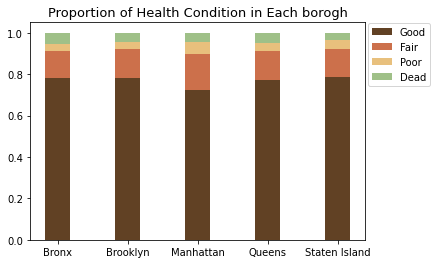

In [1109]:
borough = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
color_list = ['#7C6A0A','#1A3C40','#4E944F','#9FC088','#E9EFC0','#DACC96','#E8C07D','#CC704B','#9D5353','#632626','#614124']
x = range(len(borough))
plt.xticks(x, borough)
Bottom = borough_health['Good%']
Center1 = borough_health['Fair%']
Center2 = borough_health['Poor%']
Top = borough_health['Dead%']

B_Center1 = []
C1_Center2 =[]
for i in range(0, len(Bottom)):
    sum=Bottom[i]+Center1[i]
    B_Center1.append(sum)
    sum = Bottom[i] + Center1[i] + Center2[i]
    C1_Center2.append(sum)

width = 0.35
p1 = plt.bar(x, Bottom, width, color='#614124')  
p2 = plt.bar(x, Center1, width, bottom=Bottom, color='#CC704B')
p3 = plt.bar(x, Center2, width, bottom=B_Center1, color='#E8C07D')
p4 = plt.bar(x, Top, width, bottom=C1_Center2, color='#9FC088') 
plt.title('Proportion of Health Condition in Each borogh',fontsize=13)
plt.legend((p1[0], p2[0], p3[0],p4[0]), ('Good', 'Fair', 'Poor','Dead'),bbox_to_anchor=(1.21,1.02),loc = 'best')
plt.savefig('result/borough_health.png',bbox_inches = 'tight')
plt.show()

### zipcode & Health

In [458]:
zip_health = geo_df.groupby(['zipcode','health']).agg({
    'tree_id':'count',
}).reset_index()
zip_health = zip_health.pivot(index='zipcode',columns='health',values='tree_id')
zip_health['sum'] = zip_health.apply(lambda x: x.sum(),axis=1)
zip_health['Dead%'] = zip_health.apply(lambda x:x['Dead']/x['sum']*100,axis=1)
zip_health['Fair%'] = zip_health.apply(lambda x:x['Fair']/x['sum']*100,axis=1)
zip_health['Good%'] = zip_health.apply(lambda x:x['Good']/x['sum']*100,axis=1)
zip_health['Poor%'] = zip_health.apply(lambda x:x['Poor']/x['sum']*100,axis=1)

In [459]:
zip_health = zip_health.fillna(0)
zip_health = zip_health.reset_index()

In [460]:
zip_health.zipcode = zip_health.zipcode.astype(str)
zip_health.shape

(175, 10)

In [461]:
zips = geopandas.read_file('ZIP_CODE_040114.shp')
zips = zips[['ZIPCODE','geometry']].sort_values(by = ['ZIPCODE'],ascending = True)
zips = zips.drop_duplicates(subset=['ZIPCODE'])

In [462]:
zip_health = pd.merge(zip_health, zips, left_on = 'zipcode', right_on = 'ZIPCODE',how = 'left')
zip_health = geopandas.GeoDataFrame(zip_health)

## Demographics

In [463]:
data_nyc = pd.read_csv('nyc_income_age_ house_cost.csv')
data_nyc.zipcode=data_nyc.zipcode.astype(str)
data_pop = pd.read_csv('nyc_zip_borough_neighborhoods_pop.csv')
data_pop.zip=data_pop.zip.astype(str)
zip_health = pd.merge(zip_health, data_nyc, on='zipcode',how='inner')
zip_health = pd.merge(zip_health, data_pop.drop(columns=['borough']), left_on='zipcode',right_on='zip',how='inner')
zip_health = zip_health.drop(columns=['zip'])
zip_health

,zipcode,Dead,Fair,Good,Poor,sum,Dead%,Fair%,Good%,Poor%,ZIPCODE,geometry,Median_Individual_Income,Median_Resident_Age,Median_Monthly_House_Cost,post_office,neighborhood,population,density
0,10001,61.0,100.0,719.0,31.0,911.0,6.695939,10.976948,78.924259,3.402854,10001,"POLYGON ((981958.647 213464.453, 981980.328 21...",92840.0,36.9,1800.0,"New York, NY",Chelsea and Clinton,21102,33959
1,10002,107.0,387.0,1656.0,115.0,2265.0,4.724062,17.086093,73.112583,5.077263,10002,"POLYGON ((991339.870 207576.784, 991330.490 20...",36982.0,44.3,993.0,"New York, NY",Lower East Side,81410,92573
2,10003,82.0,361.0,1480.0,102.0,2025.0,4.049383,17.827160,73.086420,5.037037,10003,"POLYGON ((989830.469 207048.126, 989716.354 20...",11861.0,32.5,2225.0,"New York, NY",Lower East Side,56024,97188
3,10004,1.0,17.0,97.0,3.0,118.0,0.847458,14.406780,82.203390,2.542373,10004,"POLYGON ((977542.450 188447.278, 977523.000 18...",190223.0,37.4,3385.0,"New York, NY",Lower Manhattan,3089,5519
4,10005,14.0,57.0,59.0,14.0,144.0,9.722222,39.583333,40.972222,9.722222,10005,"POLYGON ((982595.679 195880.754, 982587.366 19...",189702.0,30.3,3399.0,"New York, NY",Lower Manhattan,7135,97048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,11691,356.0,1258.0,3761.0,343.0,5718.0,6.225953,22.000700,65.774746,5.998601,11691,"POLYGON ((1054519.888 162245.759, 1054622.095 ...",52562.0,31.1,1356.0,"Far Rockaway, NY",Rockaways,60035,21185
171,11692,150.0,523.0,1122.0,218.0,2013.0,7.451565,25.981123,55.737705,10.829608,11692,"POLYGON ((1041797.850 157921.399, 1041802.450 ...",48956.0,36.4,1367.0,"Arverne, NY",Rockaways,18540,18566
172,11693,156.0,288.0,518.0,207.0,1169.0,13.344739,24.636441,44.311377,17.707442,11693,"POLYGON ((1030722.649 160980.770, 1030642.283 ...",63334.0,41.5,1130.0,"Far Rockaway, NY",Rockaways,11916,11950
173,11694,396.0,833.0,1958.0,385.0,3572.0,11.086226,23.320269,54.815230,10.778275,11694,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",88701.0,48.5,1506.0,"Rockaway Park, NY",Rockaways,20408,14944


## 311

In [464]:
tree_311 = pd.read_csv('311_tree_complaint.csv')
tree_311.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,Created Day
0,29609033,01/01/2015 01:06:43 AM,01/20/2015 09:19:14 AM,DPR,Department of Parks and Recreation,Illegal Tree Damage,Branches Damaged,NaN,11417.0,133-03 96TH STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.675899,-73.840548,"(40.67589932499094, -73.84054778848972)",2015-01-01
1,29614686,01/01/2015 09:22:49 AM,11/10/2015 09:55:56 AM,DPR,Department of Parks and Recreation,New Tree Request,For One Address,NaN,11230.0,325 AVENUE M,...,NaN,NaN,NaN,NaN,NaN,NaN,40.616744,-73.971653,"(40.616743691060684, -73.97165262290905)",2015-01-01
2,29617258,01/01/2015 10:21:32 AM,01/28/2015 08:28:33 AM,DPR,Department of Parks and Recreation,Damaged Tree,Branch Cracked and Will Fall,Street,11423.0,192-63 HOLLIS AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.707703,-73.765019,"(40.70770262096205, -73.76501943349744)",2015-01-01
3,29616438,01/01/2015 11:08:14 AM,NaN,DPR,Department of Parks and Recreation,New Tree Request,For One Address,NaN,11225.0,2111 BEEKMAN PL,...,NaN,NaN,NaN,NaN,NaN,NaN,40.660221,-73.961311,"(40.66022084056072, -73.96131142741272)",2015-01-01
4,29618437,01/01/2015 11:56:20 AM,11/10/2015 08:44:41 AM,DPR,Department of Parks and Recreation,New Tree Request,For One Address,Street,11215.0,837 UNION STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.674822,-73.976358,"(40.67482164349205, -73.9763578163367)",2015-01-01


In [465]:
zip_311=tree_311.groupby('Incident Zip').agg({
    'Unique Key':'count'
}).reset_index()
zip_311 = zip_311.rename(columns={'Incident Zip':'zipcode','Unique Key':'311_count'})
zip_311.zipcode = zip_311.zipcode.astype(int).astype(str)
zip_311

,zipcode,311_count
0,24,1
1,83,1
2,10001,67
3,10002,219
4,10003,291
...,...,...
181,11691,244
182,11692,47
183,11693,56
184,11694,429


In [466]:
zip_health = pd.merge(zip_health,zip_311,on='zipcode',how='left')

In [470]:
zip_health = zip_health.fillna(0)
zip_health.isna().any()

zipcode                      False
Dead                         False
Fair                         False
Good                         False
Poor                         False
sum                          False
Dead%                        False
Fair%                        False
Good%                        False
Poor%                        False
ZIPCODE                      False
geometry                     False
Median_Individual_Income     False
Median_Resident_Age          False
Median_Monthly_House_Cost    False
post_office                  False
neighborhood                 False
population                   False
density                      False
311_count                    False
dtype: bool

Text(0.5, 1.0, '311_count')

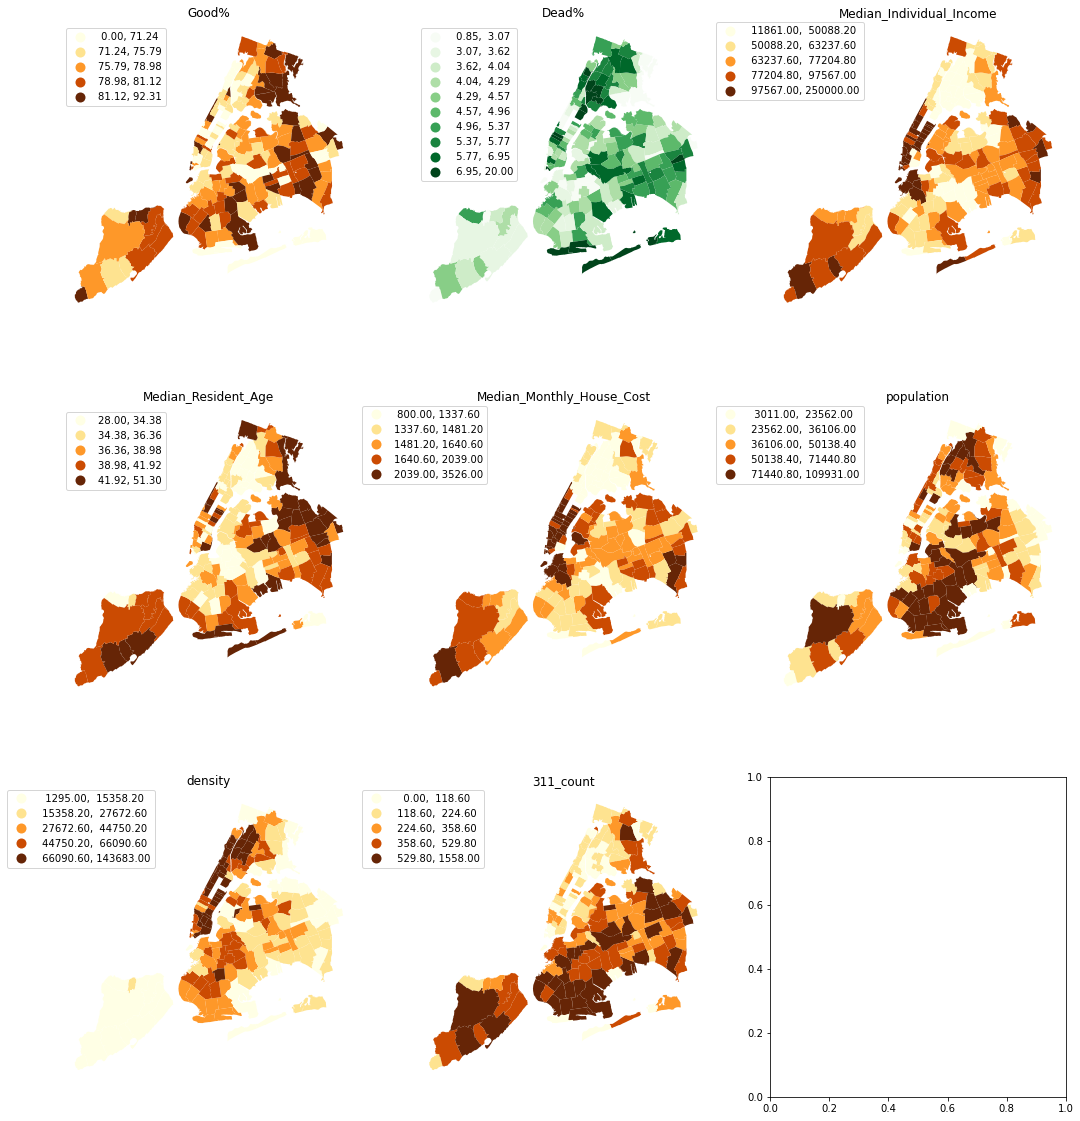

In [1001]:
fig, ax = plt.subplots(3,3,figsize=(18, 20))
ax[0][0].axis('off')
zip_health.plot(ax=ax[0][0], column='Good%', k=5, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left'},cmap='YlOrBr')
ax[0][0].set_title('Good%')

ax[0][1].axis('off')
zip_health.plot(ax=ax[0][1], column='Dead%', k=10, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left'},cmap='Greens')
ax[0][1].set_title('Dead%')

ax[0][2].axis('off')
zip_health.plot(ax=ax[0][2], column='Median_Individual_Income', k=5, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.2,1.02)},cmap='YlOrBr')
ax[0][2].set_title('Median_Individual_Income')

ax[1][0].axis('off')
zip_health.plot(ax=ax[1][0], column='Median_Resident_Age', k=5, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left'},cmap='YlOrBr')
ax[1][0].set_title('Median_Resident_Age')

ax[1][1].axis('off')
zip_health.plot(ax=ax[1][1], column='Median_Monthly_House_Cost', k=5, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.2,1.02)},cmap='YlOrBr')
ax[1][1].set_title('Median_Monthly_House_Cost')

ax[1][2].axis('off')
zip_health.plot(ax=ax[1][2], column='population', k=5, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.2,1.02)},cmap='YlOrBr')
ax[1][2].set_title('population')

ax[2][0].axis('off')
zip_health.plot(ax=ax[2][0], column='density', k=5, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.2,1.02)},cmap='YlOrBr')
ax[2][0].set_title('density')

ax[2][1].axis('off')
zip_health.plot(ax=ax[2][1], column='311_count', k=5, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.2,1.02)},cmap='YlOrBr')
ax[2][1].set_title('311_count')


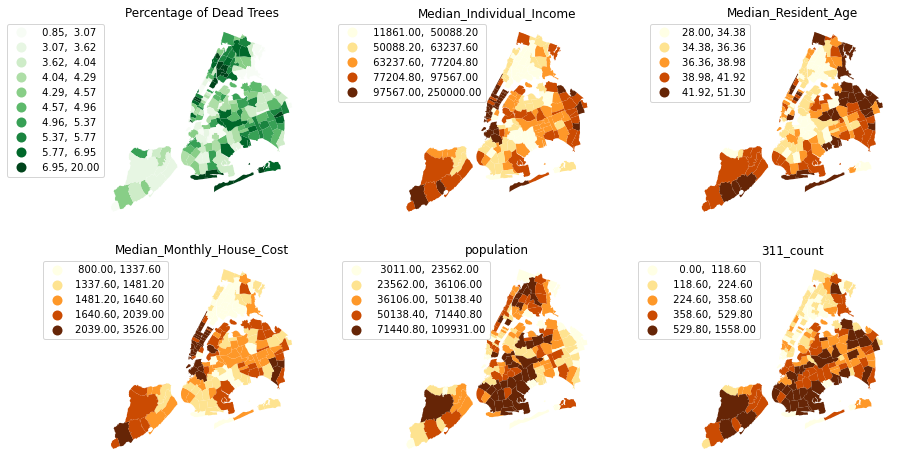

In [1161]:
fig, ax = plt.subplots(2,3,figsize=(15, 8))

ax[0][0].axis('off')
zip_health.plot(ax=ax[0][0], column='Dead%', k=10, scheme='Quantiles',legend=True,
            facecolor='lightgrey',
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.5,1.02)},colormap='Greens')
ax[0][0].set_title('Percentage of Dead Trees')

ax[0][1].axis('off')
zip_health.plot(ax=ax[0][1], column='Median_Individual_Income', k=5, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.32,1.02)},cmap='YlOrBr')
ax[0][1].set_title('Median_Individual_Income')

ax[0][2].axis('off')
zip_health.plot(ax=ax[0][2], column='Median_Resident_Age', k=5, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.24,1.02)},cmap='YlOrBr')
ax[0][2].set_title('Median_Resident_Age')

ax[1][0].axis('off')
zip_health.plot(ax=ax[1][0], column='Median_Monthly_House_Cost', k=5, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.32,1.02)},cmap='YlOrBr')
ax[1][0].set_title('Median_Monthly_House_Cost')

ax[1][1].axis('off')
zip_health.plot(ax=ax[1][1], column='population', k=5, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.3,1.02)},cmap='YlOrBr')
ax[1][1].set_title('population')


ax[1][2].axis('off')
zip_health.plot(ax=ax[1][2], column='311_count', k=5, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.3,1.02)},cmap='YlOrBr')
ax[1][2].set_title('311_count')

fig.savefig('result/zip_demo_311_dead.png')

# compare 2005 & 2015

## percentage of Good in each zipcode（05-15）
## Which areas will have large reductions in tree health


In [583]:
data_2005 = pd.read_csv('2005_Street_Tree_Census.csv')
data_2005 = data_2005.rename(columns={'census tract':'census_tract',
                          'boroname':'borough',
                          'OBJECTID':'tree_id',
                          'status':'health'
                          })
filter_2005 = data_2005[['tree_id','borough','zipcode',
                        'latitude','longitude','tree_dbh','health','spc_latin','spc_common']]
filter_2005 = filter_2005[filter_2005.zipcode != 0]

In [584]:
filter_2005.health.unique()

array(['Good', 'Poor', 'Excellent', 'Dead'], dtype=object)

In [1264]:
filter_2005.shape

(583461, 11)

In [585]:
filter_2005['health_class'] = filter_2005.apply(lambda x: '2005Good' if (x['health']=='Good') or (x['health']=='Excellent') 
                                                else '2005Bad',axis=1)


In [586]:
health_class_count_2005 = filter_2005.groupby(['zipcode','health_class']).agg({
    'tree_id':'count'
}).reset_index().rename(columns={'tree_id':'health_class_count'})
zip_tree_count_2005 = filter_2005.groupby('zipcode').agg({
    'tree_id':'count'
}).reset_index().rename(columns={'tree_id':'tree_count'})

In [587]:
zip_health_2005 = pd.merge(health_class_count_2005,zip_tree_count_2005,on='zipcode',how='left')

In [588]:
zip_health_2005['percent'] = zip_health_2005['health_class_count'] / zip_health_2005['tree_count']*100

In [589]:
zip_health_2005 = zip_health_2005.pivot(index = 'zipcode', columns='health_class', values='percent').reset_index()

In [599]:
zip_health_2005 = zip_health_2005.fillna(0)
zip_health_2005.zipcode = zip_health_2005.zipcode.astype(str)

In [600]:
zip_health_2005

health_class,zipcode,2005Bad,2005Good
0,10001,10.810811,89.189189
1,10002,16.635514,83.364486
2,10003,12.951970,87.048030
3,10004,14.864865,85.135135
4,10005,5.303030,94.696970
...,...,...,...
182,11691,13.324100,86.675900
183,11692,18.700265,81.299735
184,11693,10.743802,89.256198
185,11694,5.925926,94.074074


In [592]:
zip_health_2015 = zip_health[['zipcode','Dead','Fair','Poor','Good','sum','geometry']]
zip_health_2015['2015Good'] = (zip_health_2015['Good']+zip_health_2015['Fair'])/zip_health_2015['sum']*100
zip_health_2015['2015Bad'] = (zip_health_2015['Poor']+zip_health_2015['Dead'])/zip_health_2015['sum']*100

In [593]:
zip_health_2015

,zipcode,Dead,Fair,Poor,Good,sum,geometry,2015Good,2015Bad
0,10001,61.0,100.0,31.0,719.0,911.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",89.901207,10.098793
1,10002,107.0,387.0,115.0,1656.0,2265.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",90.198675,9.801325
2,10003,82.0,361.0,102.0,1480.0,2025.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",90.913580,9.086420
3,10004,1.0,17.0,3.0,97.0,118.0,"POLYGON ((977542.450 188447.278, 977523.000 18...",96.610169,3.389831
4,10005,14.0,57.0,14.0,59.0,144.0,"POLYGON ((982595.679 195880.754, 982587.366 19...",80.555556,19.444444
...,...,...,...,...,...,...,...,...,...
170,11691,356.0,1258.0,343.0,3761.0,5718.0,"POLYGON ((1054519.888 162245.759, 1054622.095 ...",87.775446,12.224554
171,11692,150.0,523.0,218.0,1122.0,2013.0,"POLYGON ((1041797.850 157921.399, 1041802.450 ...",81.718828,18.281172
172,11693,156.0,288.0,207.0,518.0,1169.0,"POLYGON ((1030722.649 160980.770, 1030642.283 ...",68.947819,31.052181
173,11694,396.0,833.0,385.0,1958.0,3572.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",78.135498,21.864502


In [603]:
health_dif_15_05 = pd.merge(zip_health_2015[['zipcode','geometry',
                                             '2015Good','2015Bad']],
                            zip_health_2005[['zipcode','2005Good',
                                             '2005Bad']],on='zipcode',how='inner')
health_dif_15_05['dif'] = health_dif_15_05['2015Good'] - health_dif_15_05['2005Good']
health_dif_15_05 = geopandas.GeoDataFrame(health_dif_15_05)

In [646]:
health_dif_15_05['abs_dif'] = abs(health_dif_15_05['dif'])

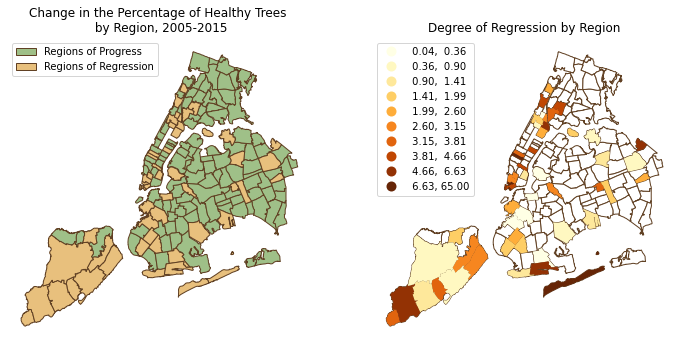

In [1162]:
fig, ax = plt.subplots(1,2,figsize=(12, 8))
health_dif_15_05.plot(ax=ax[1],edgecolor='#614124',facecolor='white')
ax[1].set_title('Degree of Regression by Region')
ax[1].axis('off')
health_dif_15_05[health_dif_15_05['dif']<=0].plot(ax=ax[1], column='abs_dif', scheme='Quantiles',k=10,legend=True,
                      legend_kwds={'loc': 'upper left'},cmap='YlOrBr')

ax[0].set_title('Change in the Percentage of Healthy Trees \n by Region, 2005-2015')
health_dif_15_05[health_dif_15_05['dif']>0].plot(ax=ax[0],
                        facecolor='#9FC088', 
                        edgecolor='#614124',                         
                        alpha=1,

                        label='2019 Hotspots'
                        )
health_dif_15_05[health_dif_15_05['dif']<=0].plot(ax=ax[0],
                        facecolor='#E8C07D',
                        edgecolor='#614124',
                        alpha=1,

                        label='2019 Hotspots'
                        )
LegendElement = [
                    mpatches.Patch(facecolor='#9FC088', label='Regions of Progress', edgecolor='#614124'),
                    mpatches.Patch(facecolor='#E8C07D', label='Regions of Regression',edgecolor='#614124'),
                ]
ax[0].legend(handles = LegendElement, loc='upper left')
ax[0].axis('off')
fig.savefig('result/Good%_zip_05_15.png')

## percentage of Good in diferent families（05-15）
## which species are more likely to thrive

In [666]:
family_health_2015 = process_data
family_health_2015['health_class'] = family_health_2015.apply(lambda x:'2015Bad' if x['health']=='Poor' 
                                                              else '2015Good',axis=1)
family_health_2015 = family_health_2015.groupby(['family','health_class']).agg({
    'tree_id':'count'
}).reset_index()
family_count_2015 = process_data.groupby(['family']).agg({
    'tree_id':'count'
}).reset_index()
family_health_2015['percent'] = family_health_2015.apply(lambda x: int(x['tree_id']) /
                                               int(family_count_2015[family_count_2015['family']==x['family']]['tree_id']) * 100, axis=1 )
family_health_2015 = family_health_2015.pivot(index='family',columns='health_class',values='percent').reset_index()


In [850]:
import pickle
with open('tree_family.pkl','rb') as f:
    family = pickle.load(f)
tree_map = {}
for k,v in family.items():
    for item in v:
        tree_map[item]=k
# tree_map[np.nan]=np.nan
# filter_2005['family'] = filter_2005.apply(lambda x: tree_map[x['spc_common']],
#                                     axis=1)

In [852]:
family['Fabaceae'] = family.get('Fabaceae',[])+['yellowood']
family['Pinaceae'] = family.get('Pinaceae',[])+['douglas fir','tamarack','fir, balsam']
family['Salixaceae'] = family.get('Salixaceae',[])+['poplar, other','poplar, lombardy']
family['Hamamelidaceae'] = family.get('Hamamelidaceae',[])+['witch hazel']
family['Paulowniaceae'] = family.get('Paulowniaceae',[])+['royal paulownia']
family['Moraceae'] = family.get('Moraceae',[])+['osage-orange']
family['Ericaceae'] = family.get('Ericaceae',[])+['sourwood']
family['Cupressaceae'] = family.get('Cupressaceae',[])+['juniper spp.']
family['Juglandaceae'] = family.get('Juglandaceae',[])+['pecan']
family['Elaeagnaceae'] = family.get('Elaeagnaceae',[])+['russian olive']

In [831]:
with open('tree_family.pkl','wb') as f:
    pickle.dump(family,f)

In [826]:
def family_2005(spc):
    for key in family.keys():
        if any([w in spc and w for w in family[key]]):
            return key
        else:
            for w in family[key]:
                if any([item in spc and item for item in w.split(' ')]):
                    return key
    return np.nan


In [854]:
filter_2005['spc_common'] = filter_2005['spc_common'].str.lower()
filter_2005['family'] = filter_2005.apply(lambda x:family_2005(x['spc_common']), axis=1)
known_2005 = filter_2005[~filter_2005['spc_common'].isin(['unknown','unknown dead'])]

In [855]:
family_health_2005 = known_2005.groupby(['family','health_class']).agg({
    'tree_id':'count'
}).reset_index()
family_count_2005 = known_2005.groupby(['family']).agg({
    'tree_id':'count'
}).reset_index()
family_health_2005['percent'] = family_health_2005.apply(lambda x: int(x['tree_id']) /
                                               int(family_count_2005[family_count_2005['family']==x['family']]['tree_id']) * 100, axis=1 )
family_health_2005 = family_health_2005.pivot(index='family',columns='health_class',values='percent').reset_index()
family_health_2005 = family_health_2005.fillna(0)


In [871]:
family_set = set(family_count_2015.sort_values('tree_id',ascending=False).head(10).family.values)\
| set(family_count_2005.sort_values('tree_id',ascending=False).head(10).family.values)

In [926]:
family_dif_15_05 = pd.merge(family_health_2005,family_health_2015,on='family',how='outer')
family_dif_15_05 = family_dif_15_05.fillna(0)
family_dif_15_05['dif'] = family_dif_15_05['2015Good'] - family_dif_15_05['2005Good']
# family_dif_15_05 = family_dif_15_05.reset_index()
top10_family_15_05 = family_dif_15_05[family_dif_15_05['family'].isin(family_set)]

In [927]:
top10_family_15_05 = top10_family_15_05.reset_index()

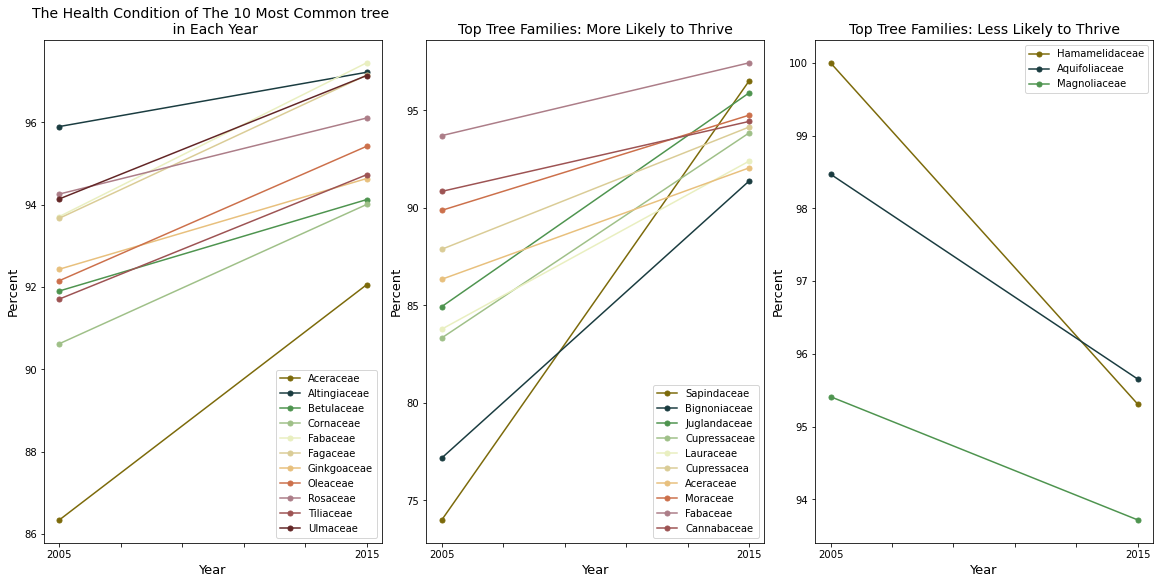

In [1121]:
fig, ax = plt.subplots(1,3,figsize=(16, 8),constrained_layout=True)
# plt.title("The Health Status of The 10 Most Common tree in Each Year")
color_list = ['#7C6A0A','#1A3C40','#4E944F','#9FC088','#E9EFC0','#DACC96','#E8C07D','#CC704B','#AC7D88','#9D5353','#632626','#614124']
years = ['2005', '2015']
x = range(len(years))
for i in range(0,len(top10_family_15_05)-1):
    ax[0].plot(x,top10_family_15_05.loc[i][['2005Good','2015Good']],marker='.', ms=10, label=top10_family_15_05.family.values[i], color=color_list[i])

ax[0].legend()
ax[0].set_xticklabels(['','2005','','','','','2015'])
ax[0].set_xlabel("Year",fontsize=13) 
ax[0].set_ylabel("Percent",fontsize=13) 
ax[0].set_title("The Health Condition of The 10 Most Common tree \n in Each Year",fontsize=14)
# ax[0].set_title('The 10 Most Common tree in 2005')

data = family_dif_15_05.sort_values('dif',ascending=False).iloc[8:18,:].reset_index()
for i in range(0,len(data)):
    ax[1].plot(x,data.loc[i][['2005Good','2015Good']],marker='.', ms=10, label=data.family.values[i], color=color_list[i])
ax[1].set_title("Top Tree Families: More Likely to Thrive",fontsize=14)
ax[1].set_xticklabels(['','2005','','','','','2015'])
ax[1].set_xlabel("Year",fontsize=13) 
ax[1].set_ylabel("Percent",fontsize=13) 
ax[1].legend()

data = family_dif_15_05.sort_values('dif',ascending=True)
data = data[data['2015Good']!=0].reset_index()
data = data.iloc[0:3,:]
for i in range(0,len(data)):
    ax[2].plot(x,data.loc[i][['2005Good','2015Good']],marker='.', ms=10, label=data.family.values[i], color=color_list[i])
ax[2].set_title("Top Tree Families: Less Likely to Thrive",fontsize=14)
ax[2].set_xticklabels(['','2005','','','','','2015'])
ax[2].set_xlabel("Year",fontsize=13) 
ax[2].set_ylabel("Percent",fontsize=13) 
ax[2].legend()
fig.savefig('result/Good%_family_05_15.png')
plt.show()

In [1038]:
process_data[process_data['zipcode']==10451]

,tree_id,borough,zipcode,latitude,longitude,tree_dbh,spc_common,health,Median_Individual_Income,Median_Resident_Age,...,post_office,neighborhood,population,density,family,health_class,borough_class,tree_class,tree_family_class,comlaint_count
630403,249407,Bronx,10451,40.812113,-73.928818,2,English oak,Poor,30349.0,34.5,...,"Bronx, NY",High Bridge and Morrisania,45713,45043,Fagaceae,2015Bad,4,1.0,2,64.0
630404,249406,Bronx,10451,40.812072,-73.928762,5,English oak,Good,30349.0,34.5,...,"Bronx, NY",High Bridge and Morrisania,45713,45043,Fagaceae,2015Good,4,1.0,2,64.0
630405,249202,Bronx,10451,40.813902,-73.926390,5,northern red oak,Fair,30349.0,34.5,...,"Bronx, NY",High Bridge and Morrisania,45713,45043,Fagaceae,2015Good,4,1.0,2,64.0
630406,249224,Bronx,10451,40.815422,-73.924200,11,honeylocust,Good,30349.0,34.5,...,"Bronx, NY",High Bridge and Morrisania,45713,45043,Fabaceae,2015Good,4,1.0,3,64.0
630407,249225,Bronx,10451,40.815445,-73.924292,10,honeylocust,Good,30349.0,34.5,...,"Bronx, NY",High Bridge and Morrisania,45713,45043,Fabaceae,2015Good,4,1.0,3,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632659,151082,Bronx,10451,40.828690,-73.921977,12,honeylocust,Good,30349.0,34.5,...,"Bronx, NY",High Bridge and Morrisania,45713,45043,Fabaceae,2015Good,4,1.0,3,64.0
632660,151076,Bronx,10451,40.827920,-73.922406,13,honeylocust,Good,30349.0,34.5,...,"Bronx, NY",High Bridge and Morrisania,45713,45043,Fabaceae,2015Good,4,1.0,3,64.0
632661,151071,Bronx,10451,40.827344,-73.922727,6,Sophora,Good,30349.0,34.5,...,"Bronx, NY",High Bridge and Morrisania,45713,45043,Fabaceae,2015Good,4,1.0,3,64.0
632662,151081,Bronx,10451,40.828471,-73.922099,9,Sophora,Good,30349.0,34.5,...,"Bronx, NY",High Bridge and Morrisania,45713,45043,Fabaceae,2015Good,4,1.0,3,64.0


In [1047]:
filter_2005[(filter_2005.zipcode==10451) & (filter_2005.health=='Dead')]

,tree_id,borough,zipcode,latitude,longitude,tree_dbh,health,spc_latin,spc_common,health_class,family
53902,646268,Bronx,10451,40.818622,-73.921478,5,Dead,Unknown Dead,unknown dead,2005Bad,NaN
62750,655118,Bronx,10451,40.812472,-73.926163,4,Dead,Unknown Dead,unknown dead,2005Bad,NaN
62769,655137,Bronx,10451,40.815474,-73.925217,11,Dead,Unknown Dead,unknown dead,2005Bad,NaN
63265,655635,Bronx,10451,40.827657,-73.924842,5,Dead,Unknown Dead,unknown dead,2005Bad,NaN
65771,658142,Bronx,10451,40.822310,-73.928974,1,Dead,Unknown Dead,unknown dead,2005Bad,NaN
65816,658187,Bronx,10451,40.825998,-73.923135,4,Dead,Unknown Dead,unknown dead,2005Bad,NaN
65851,658222,Bronx,10451,40.820084,-73.927911,0,Dead,Unknown Dead,unknown dead,2005Bad,NaN
67767,660139,Bronx,10451,40.823756,-73.927155,0,Dead,Unknown Dead,unknown dead,2005Bad,NaN
68883,661256,Bronx,10451,40.820650,-73.929594,10,Dead,Unknown Dead,unknown dead,2005Bad,NaN
74183,666511,Bronx,10451,40.822310,-73.928974,10,Dead,Unknown Dead,unknown dead,2005Bad,NaN


In [1008]:
live_2005 = filter_2005[filter_2005.health!='Dead']
live_2015 = process_data[process_data.health!='Dead']

In [1052]:
zip_count_2005 = live_2005.groupby('zipcode').agg({
    'tree_id':'count'
}).reset_index().rename(columns={'tree_id':'2005count'})
zip_count_2015 = live_2015.groupby('zipcode').agg({
    'tree_id':'count'
}).reset_index().rename(columns={'tree_id':'2015count'})
zip_count_05_15 = pd.merge(zip_count_2005,zip_count_2015,on='zipcode',how='outer')
zip_count_05_15 = zip_count_05_15.dropna()
zip_count_05_15['diff'] = zip_count_05_15['2015count'] - zip_count_05_15['2005count']
zip_count_05_15.zipcode = zip_count_05_15.zipcode.astype(str)
zip_count_05_15 = pd.merge(zip_count_05_15, zip_health_2015,on='zipcode',how='left')[['zipcode','2005count','2015count','diff','geometry']]
zip_count_05_15 = geopandas.GeoDataFrame(zip_count_05_15)

# zip_count_2015.zipcode = zip_count_2015.zipcode.astype(str)
# zip_count_2015 = pd.merge(zip_count_2015, zip_health_2015,on='zipcode',how='left')[['zipcode','count','geometry']]
# zip_count_2015 = geopandas.GeoDataFrame(zip_count_2015)
# zip_count_2005['diff'] = zip_count_2015['count'] - zip_count_2005['count']
# zip_count_2015['diff'] = zip_count_2015['count'] - zip_count_2005['count']

In [1053]:
zip_count_05_15.sort_values('diff',ascending=True)

,zipcode,2005count,2015count,diff,geometry
50,10312,22629.0,21261.0,-1368.0,"POLYGON ((928850.453 143511.403, 928874.915 14..."
72,10471,3118.0,1796.0,-1322.0,"POLYGON ((1016890.089 269622.944, 1017856.999 ..."
124,11357,10247.0,8949.0,-1298.0,"POLYGON ((1032754.160 229746.959, 1032795.350 ..."
154,11420,6153.0,5187.0,-966.0,"POLYGON ((1037510.873 189653.942, 1037527.215 ..."
140,11375,7641.0,6692.0,-949.0,"POLYGON ((1024087.848 207717.141, 1024197.644 ..."
...,...,...,...,...,...
58,10457,1878.0,3879.0,2001.0,"POLYGON ((1011926.556 251674.453, 1012170.822 ..."
114,11233,2505.0,4576.0,2071.0,"POLYGON ((1001383.645 188443.122, 1002194.410 ..."
57,10456,1571.0,3717.0,2146.0,"POLYGON ((1008285.147 245256.079, 1008368.408 ..."
89,11207,4559.0,8206.0,3647.0,"POLYGON ((1010961.260 190844.518, 1010984.556 ..."


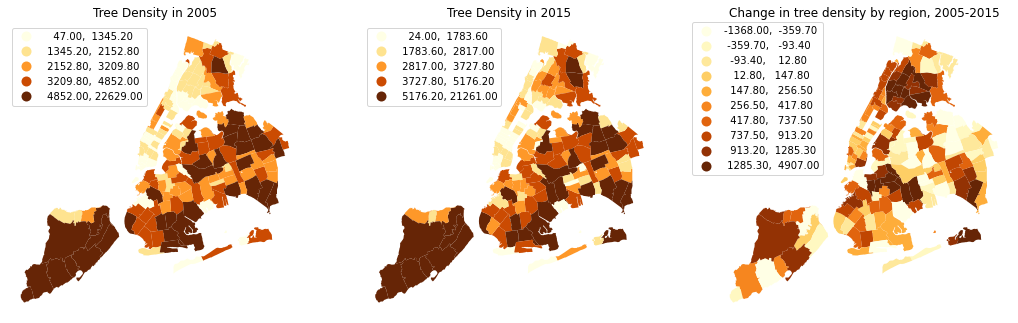

In [1165]:
fig, ax = plt.subplots(1,3,figsize=(18, 6))
ax[0].axis('off')
zip_count_05_15.plot(ax=ax[0], column='2005count', k=5, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left'},cmap='YlOrBr')
ax[0].set_title('Tree Density in 2005')

ax[1].axis('off')
zip_count_05_15.plot(ax=ax[1], column='2015count', k=5, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left'},cmap='YlOrBr')
ax[1].set_title('Tree Density in 2015')

ax[2].axis('off')
zip_count_05_15.plot(ax=ax[2], column='diff', k=10, scheme='Quantiles',legend=True,
            legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.1,1.02)},cmap='YlOrBr')
ax[2].set_title('Change in tree density by region, 2005-2015')
fig.savefig('result/tree_density_05_15.png')